Gmaug Real State Investment Opportunity Analysis
======

## Objective
Help Gmaug figure out **where to invest** in this booming market by **identifying "undervalued" properties** which he can buy, spruce up and sell for a profit.

## Approach
After performing EDA and learning more about the data and which features could be useful in determining similarities between houses, the following techniques were applied with the goal of identifying "undervalued" properties:
1. Heuristic (First Iteration Complete)
2. K-prototype (WIP)
3. K-mean (WIP)
4. Regression (WIP)

The Heuristic approach provided the first set of meaningful results. The idea was to use this as a baseline and find other methods that could provide more accurate results but due to time constraints the other approaches weren't able to be explored fully.

## Key Findings

Through the Heuristic approach, I was able to find 8,280 houses that are considered undervalued (their selling price was about 40% of the average price of similar houses sold in the current market).

These houses were selected as undervalued because if bought for their "old" sale price and sold for their "new" sale price, the ROI would be at least 150% (more than double the investment). This means that even accounting for remodeling costs (and other expenses), there is still enough room to make a profit.

**Where to invest?** Roughly 20% of the undervalued houses can be found in the area "Gap of Rohan", therefore it is recommended as a good start where one can start investing.

## Next Steps

1. Current evaluation of results was done manually, therefore it would be recommended to define a more robust/scalable evaluation method.
2. Find a way to calculate the margin of error of the current model.
3. Continue optimizing the clustering and regression models and then compare their results to heuristic approach. These approaches are considered more scalable.

# 1. Import
*Import libraries and data in preparation for analysis*

In [1]:
!pip install pip install kmodes
!pip install prince

In [2]:
import seaborn as sns
import pandas as pd
import json
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
import prince
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import chi2_contingency
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats
from sklearn.linear_model import HuberRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings('ignore')

In [3]:
me_df = pd.read_csv("/Users/andresvourakis/Documents/Playground/Viaplay/lotr-housing-sales.txt")

In [4]:
me_df.head()

,epoch.of.history,address,area,dwelling.type,dwell.sub.type,tax.class,sale.date,sale.price,year.built,number.of.units,land.area,building.area
0,Fourth Age,2206 Mandos Way,Minas Tirith,One Family,Human house,A1,1241-02-20,300000.0,1131,1.0,1103.0,1290.0
1,Fourth Age,4312 W Rauros Circle,Minas Tirith,One Family,Hobbit hole,S1,1241-07-01,400000.0,1131,1.0,2500.0,2452.0
2,Fourth Age,2504 Harad Circle,Minas Tirith,One Family,Human house,S0,1241-01-06,510000.0,1152,1.0,1911.0,4080.0
3,Fourth Age,1087 Moria Circle,Minas Tirith,Two Family,Hobbit hole,B1,1241-08-04,430000.0,1214,2.0,2000.0,2400.0
4,Fourth Age,1904 Túna Street,Minas Tirith,Two Family,Hobbit hole,B1,1241-01-29,389000.0,1216,2.0,2451.0,2394.0


# 2. Pre-process
*Pre-process data in preparation for analysis in order to make it easier to work with*

In [5]:
def check_data(df):
    # Generates a concise summary of DataFrame columns.
    
# We use list comprehension to iterate over each column
    summary = [
        [col, df[col].dtype, df[col].count(), df[col].nunique(), df[col].isnull().sum(), df.duplicated().sum()]
        for col in df.columns
    ]
# Create a DataFrame from the list of lists
    df_check = pd.DataFrame(summary, columns=["column", "dtype", "instances", "unique", "sum_null", "duplicates"])

    return df_check

In [6]:
# Let's remove rows where building.area is 0
me_df = me_df[me_df['building.area'] != 0]

# 3. Analysis

## 3.1 Exploratory Data Analysis (EDA)
Perform EDA to familiarise myself with the data and help determine potential best features

In [7]:
display("Middle Earth", me_df.head(5), me_df.tail(5), me_df.shape)

'Middle Earth'

,epoch.of.history,address,area,dwelling.type,dwell.sub.type,tax.class,sale.date,sale.price,year.built,number.of.units,land.area,building.area
0,Fourth Age,2206 Mandos Way,Minas Tirith,One Family,Human house,A1,1241-02-20,300000.0,1131,1.0,1103.0,1290.0
1,Fourth Age,4312 W Rauros Circle,Minas Tirith,One Family,Hobbit hole,S1,1241-07-01,400000.0,1131,1.0,2500.0,2452.0
2,Fourth Age,2504 Harad Circle,Minas Tirith,One Family,Human house,S0,1241-01-06,510000.0,1152,1.0,1911.0,4080.0
3,Fourth Age,1087 Moria Circle,Minas Tirith,Two Family,Hobbit hole,B1,1241-08-04,430000.0,1214,2.0,2000.0,2400.0
4,Fourth Age,1904 Túna Street,Minas Tirith,Two Family,Hobbit hole,B1,1241-01-29,389000.0,1216,2.0,2451.0,2394.0


,epoch.of.history,address,area,dwelling.type,dwell.sub.type,tax.class,sale.date,sale.price,year.built,number.of.units,land.area,building.area
139653,Fourth Age,3913 Window-Curtain Road,Ciril,Two Family,Orc lair,B9,1246-04-23,665000.0,1219,2.0,2590.0,1850.0
139654,Fourth Age,564 Lands Without Circle,Ciril,Two Family,Elf house,B2,1246-11-10,775000.0,1221,2.0,5235.0,2400.0
139655,Fourth Age,2807 Girdley Island Road,Ciril,Two Family,Orc lair,B9,1246-06-18,500000.0,1222,2.0,2385.0,2250.0
139656,Fourth Age,400 Cirith Dúath Parkway,Ciril,Two Family,Human house,B9,1246-09-25,537000.0,1222,2.0,2728.0,1980.0
139657,Fourth Age,264 Western Shore Circle,Ciril,Two Family,Hobbit hole,B9,1246-10-09,525000.0,1222,2.0,2472.0,1980.0


(138901, 12)

In [8]:
print("A Summary of each column in the dataset")
check_data(me_df)

A Summary of each column in the dataset


,column,dtype,instances,unique,sum_null,duplicates
0,epoch.of.history,object,138901,1,0,0
1,address,object,138901,138901,0,0
2,area,object,138901,29,0,0
3,dwelling.type,object,138901,3,0,0
4,dwell.sub.type,object,138901,4,0,0
5,tax.class,object,138901,18,0,0
6,sale.date,object,138746,1892,155,0
7,sale.price,float64,138901,12100,0,0
8,year.built,int64,138901,157,0,0
9,number.of.units,float64,138668,20,233,0


**Observations:**
* The dataset contains almost 140K rows with 12 columns.
* Each row represents a property and all rows are unique, meaning there are exactly 139,658 properties.
* Each column provides some general information about the property such as property type, sale price, and year built.
* There are some rows that contain missing information for sale.price, number.of.units, land.area and building.area. There is no missing entries for the rest of the columns. 

In [9]:
print("A statistical summary of each numeric column in the dataframe")
me_df.describe().transpose()

A statistical summary of each numeric column in the dataframe


,count,mean,std,min,25%,50%,75%,max
sale.price,138901.0,761751.701305,900249.014163,30500.0,442000.0,618000.0,866169.0,87400000.0
year.built,138901.0,1163.120453,30.809629,271.0,1141.0,1152.0,1181.0,1241.0
number.of.units,138668.0,1.582081,0.704631,0.0,1.0,1.0,2.0,69.0
land.area,138668.0,3028.372133,1970.179883,200.0,2000.0,2500.0,3800.0,91620.0
building.area,138668.0,1939.525860,872.957454,1.0,1332.0,1764.0,2346.0,71448.0


**Observations:**
* The cheapest property costs 30,500 castars and the most expensive costs 87,400,000 castars.
* 75% of properties have 2 units or less. While the house with the most units has 69 units.

In [10]:
def extract_year(date_str):
    if pd.isna(date_str) or date_str == 'nan':
        return None
    try:
        # Strip out time component if it exists
        date_str = date_str.split()[0]
        year = int(date_str.split('-')[0])
        return year
    except Exception as e:
        print(f"Error extracting year from date {date_str}: {e}")
        return None


In [11]:
# Apply the extraction function to the DataFrame
me_df['sale_year'] = me_df['sale.date'].apply(extract_year)

# Calculate distribution of houses per area
date_counts = me_df['sale_year'].value_counts().reset_index()
date_counts.columns = ['sale_year', 'count']

total = date_counts['count'].sum()
date_counts['percentage'] = (date_counts['count'] / total) * 100

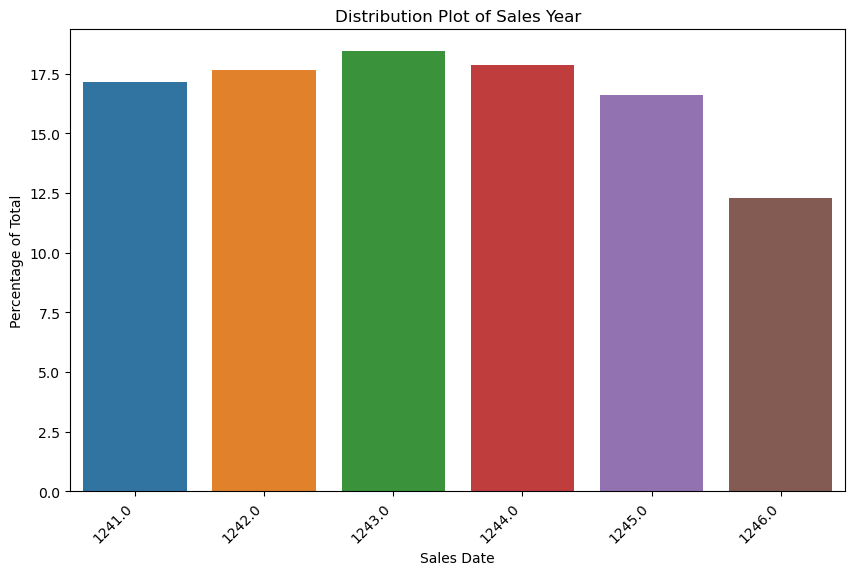

In [12]:
plt.figure(figsize=(10, 6))
sns.barplot(x='sale_year', y='percentage', data=date_counts)
#plt.ylim(0, 100)  # Set y-axis limits from 0 to 100
plt.ylabel('Percentage of Total')
plt.xlabel('Sales Date')
plt.title('Distribution Plot of Sales Year')
plt.xticks(rotation=45, ha='right')
plt.show()

In [13]:
# Calculate distribution of houses per area
area_counts = me_df['area'].value_counts().reset_index()
area_counts.columns = ['area', 'count']

total = area_counts['count'].sum()
area_counts['percentage'] = (area_counts['count'] / total) * 100

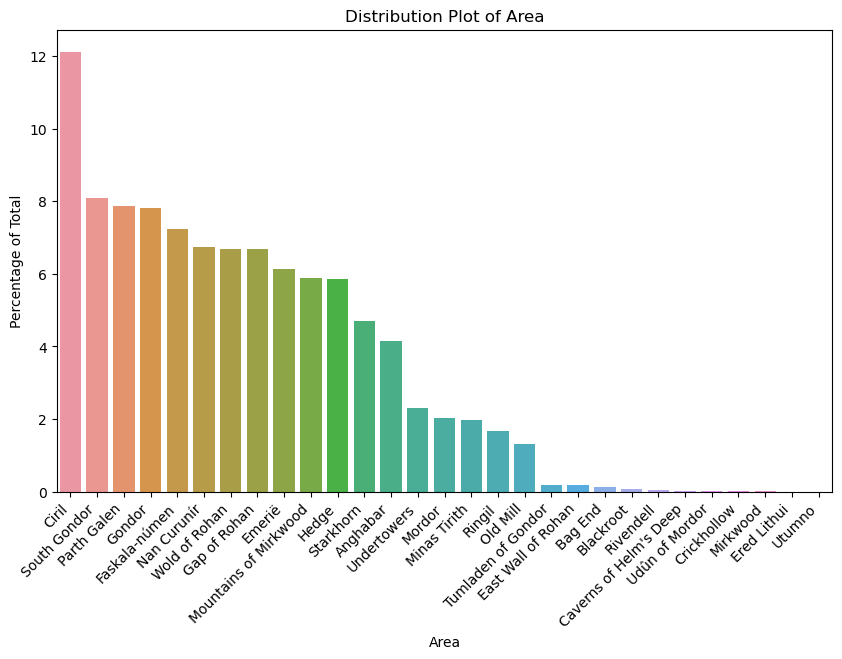

In [14]:
plt.figure(figsize=(10, 6))
sns.barplot(x='area', y='percentage', data=area_counts)
#plt.ylim(0, 100)  # Set y-axis limits from 0 to 100
plt.ylabel('Percentage of Total')
plt.xlabel('Area')
plt.title('Distribution Plot of Area')
plt.xticks(rotation=45, ha='right')
plt.show()

**Observations:** Out of 29 areas, the most popular area is "Ciril", where 12% of total houses are found. 

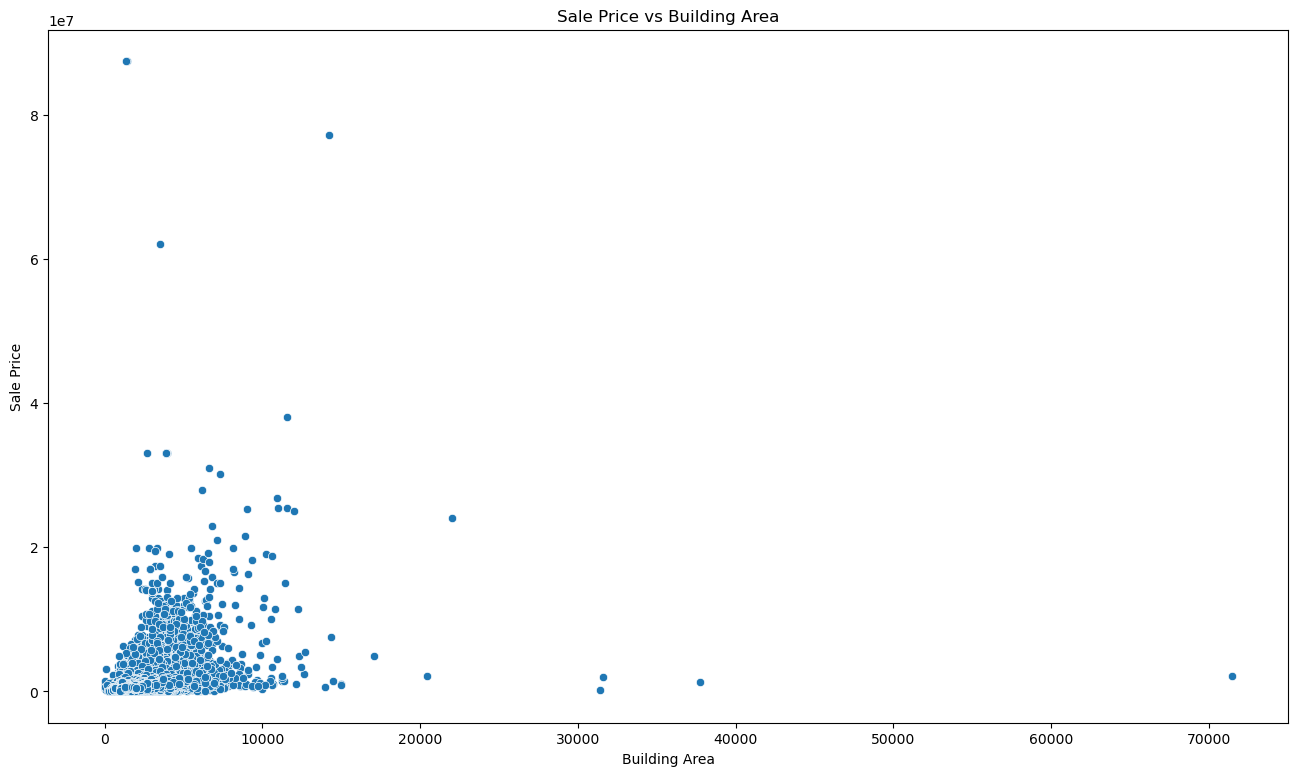

In [15]:
plt.figure(figsize=(16, 9))
sns.scatterplot(data=me_df, x="building.area", y="sale.price")
plt.title("Sale Price vs Building Area")
plt.xlabel("Building Area")
plt.ylabel("Sale Price")
plt.show()

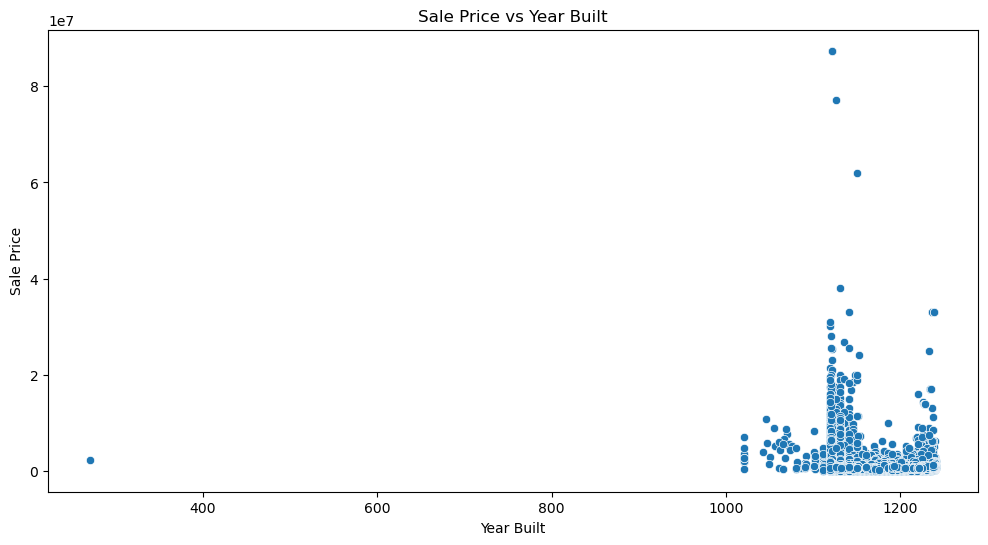

In [16]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=me_df, x="year.built", y="sale.price")
plt.title("Sale Price vs Year Built")
plt.xlabel("Year Built")
plt.ylabel("Sale Price")
plt.show()

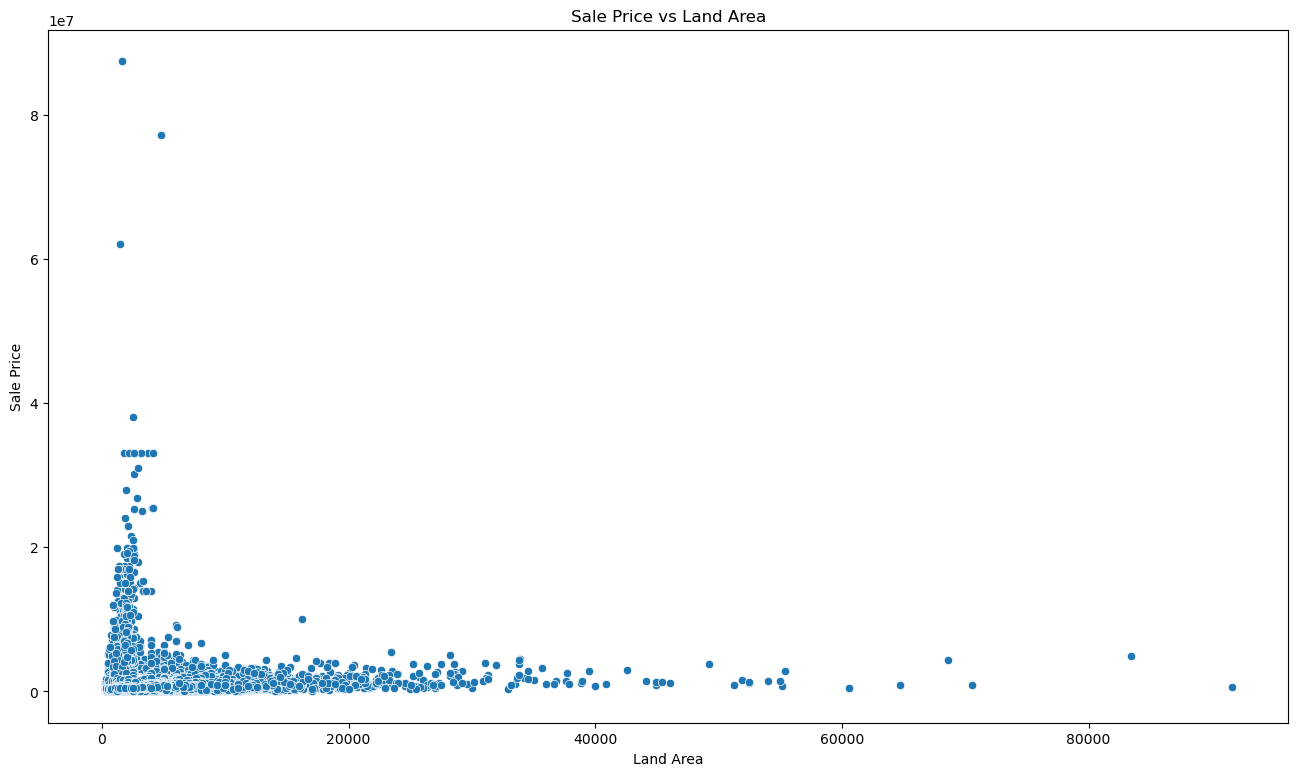

In [17]:
plt.figure(figsize=(16, 9))
sns.scatterplot(data=me_df, x="land.area", y="sale.price")
plt.title("Sale Price vs Land Area")
plt.xlabel("Land Area")
plt.ylabel("Sale Price")
plt.show()

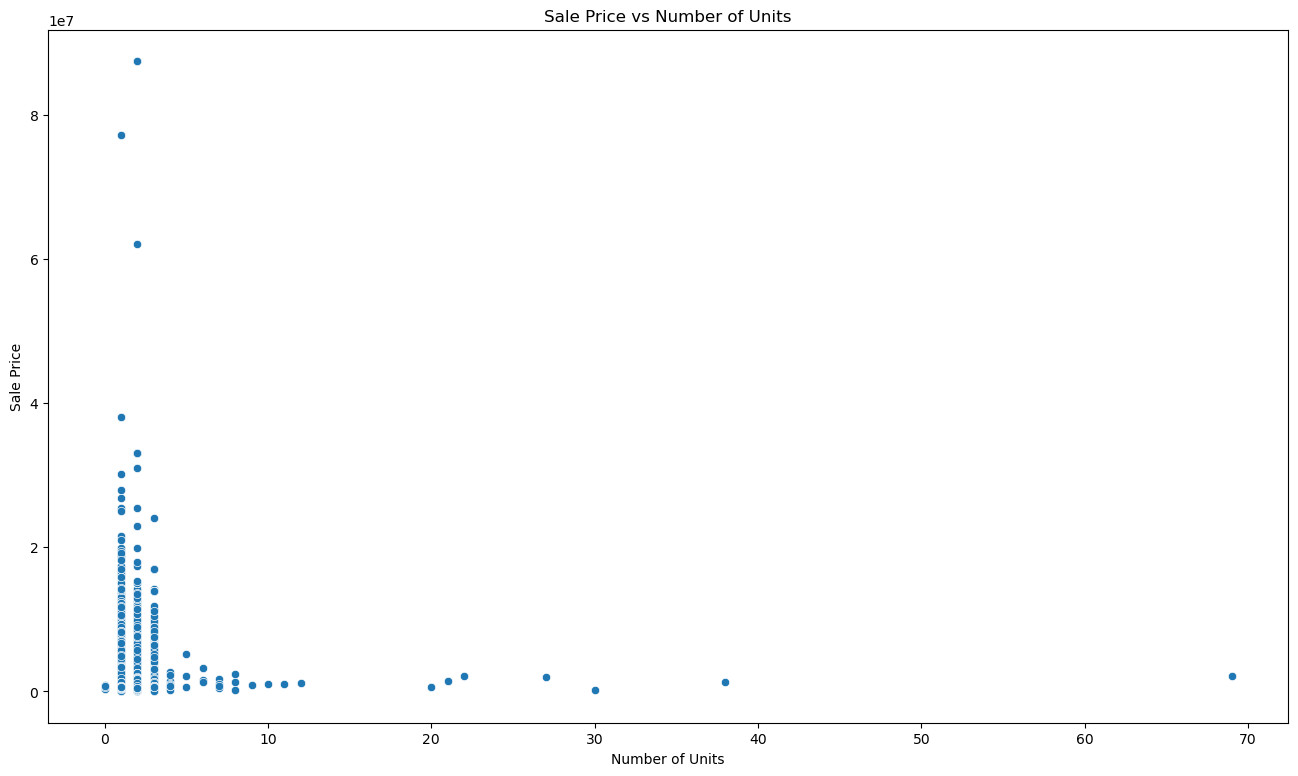

In [18]:
plt.figure(figsize=(16, 9))
sns.scatterplot(data=me_df, x="number.of.units", y="sale.price")
plt.title("Sale Price vs Number of Units")
plt.xlabel("Number of Units")
plt.ylabel("Sale Price")
plt.show()

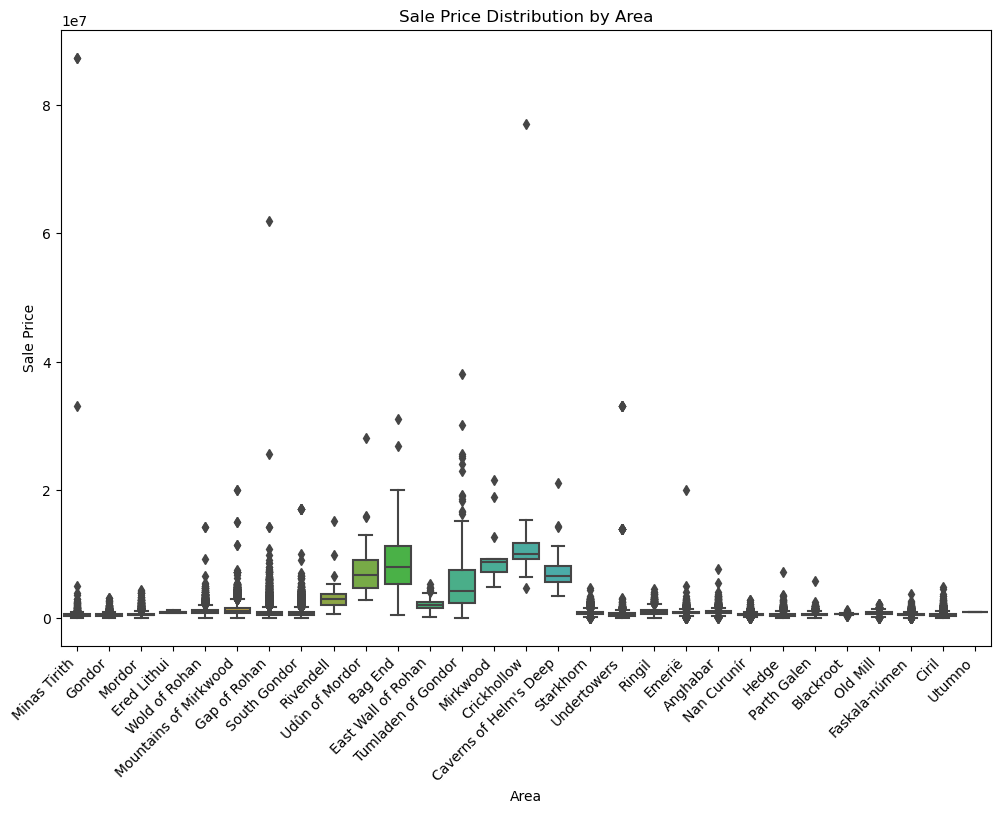

In [19]:
# Box plot to visualize the distribution of sale prices across cities
plt.figure(figsize=(12, 8))
sns.boxplot(x='area', y='sale.price', data=me_df)
plt.title('Sale Price Distribution by Area')
plt.xlabel('Area')
plt.ylabel('Sale Price')
plt.xticks(rotation=45, ha='right')
plt.show()

In [20]:
from scipy.stats import f_oneway

# Perform ANOVA
groups = me_df.groupby('area')['sale.price'].apply(list)
anova_result = f_oneway(*groups)
print(f"ANOVA F-statistic: {anova_result.statistic:.3f}, p-value: {anova_result.pvalue:.3f}")

ANOVA F-statistic: 2199.503, p-value: 0.000


 **Observation:** The results indicate that there is a statistical significant different in sale prices between areas

In [21]:
# Calculate mean sale price for each city
city_mean_price = me_df.groupby('area')['sale.price'].mean()

# Create a new feature for price deviation from city mean
me_df['price_deviation_area'] = me_df.apply(lambda row: row['sale.price'] - city_mean_price[row['area']], axis=1)

In [22]:
# Extract all of the numerical columns from the dataset
numerical_me_df = me_df.select_dtypes(include=['int64', 'float64'])

In [23]:
corr_matrix = numerical_me_df.corr()
corr_matrix.head()

,sale.price,year.built,number.of.units,land.area,building.area,sale_year,price_deviation_area
sale.price,1.000000,-0.099397,0.120008,0.034647,0.362755,0.088596,0.832330
year.built,-0.099397,1.000000,-0.072019,0.078837,0.039097,0.019842,0.009587
number.of.units,0.120008,-0.072019,1.000000,-0.109658,0.565887,-0.029043,0.071662
land.area,0.034647,0.078837,-0.109658,1.000000,0.162588,0.006894,0.127027
building.area,0.362755,0.039097,0.565887,0.162588,1.000000,-0.036828,0.270572


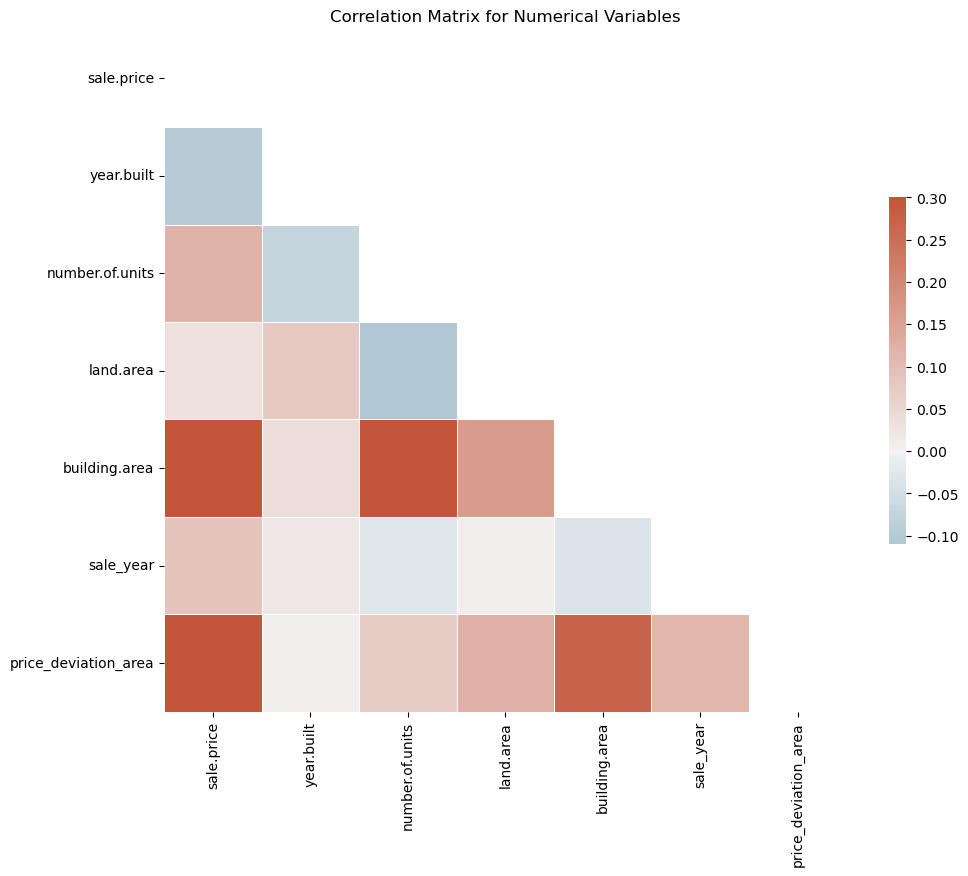

In [24]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.title("Correlation Matrix for Numerical Variables")

plt.show()

**Observations:** Based on the correlation matrix, the two features with the highest correlation with sale.price are:
1. building.area
2. price_deviation_area

*These are two numerical features we could use for clustering or regression*

## 3.2 Finding Undervalued Houses
In this section I apply different techniques to help answer the main questions of the analysis.

### Approach Overview
The following techniques were applied in this section in order to determine which would be best suited to complete the analysis based on the objective at hand:
1. **Heuristic (First iteration complete):** The idea with this approach was to make a comparison between the price of houses sold in the "old market" (before 1245) vs the price of similar houses sold in the "new market" (between 1245-1246) in order to determine whether a house is currently undervalued.
3. **K-mean (WIP):** The main idea with this approach was to cluster houses based on similarities in their physical attributes and location, and then investigate each cluster to find houses that are significant below the average price per square meter.
4. **K-prototype (WIP):** The idea was the same as in the "K-mean approach", but K-prototype was used here instead since it allows for categorical variables as features.
5. **Regression (WIP):** The idea was similar to the "Heuristic approach" used to separate houses into "old market" and "new market" categories. However, in this case, we used regression techniques to train a predictive model with the data from the "new market" houses. This model was then applied to predict the sale prices of houses in the "old market". By comparing the actual sale prices with the predicted prices, we aimed to identify undervalued houses.

In [25]:
columns_to_use = ['year.built', 'area', 'dwell.sub.type']
clustering_features_raw = me_df[columns_to_use]

scaler = StandardScaler()
clustering_features_encoded = pd.get_dummies(clustering_features_raw, columns=columns_to_use)
clustering_features = scaler.fit_transform(clustering_features_encoded)

### Heuristic

#### Define constraints

**Assumptions:**<br>
* Houses that were sold during the last two years, 1245-1246, are consider to reflect current market prices
* Houses that were sold before the past two years, before 1245, are consider to have outdated market prices

**Approach:**<br>
With these assumptions in mind, the approach to determine if a house is undervalued or notZ, will be to compare the price between the house in the old market with the price of similar houses in the new market. In order to determine if houses are similar, we will look at a set of attributes which in this case are a combination of physical attributes (e.g. building.area) and location (e.g. area).

Then, in order to determine if a house in the old market is undervalued or not, we will do the following:
1. Find all houses in the new market that are similar to it based on the attributes defined.
2. Calculate the average price of houses in the new market with similar attributes.
3. Compare the price of the house in the old market with the average price calculated.
4. If the difference goes beyond the predefined threshold, labeled the house as "undervalued"

  

In [26]:
# Define the cutoff date for "old" and "new" houses
cutoff_date = 1245

# Separate old and new houses
old_market_houses = me_df[me_df['sale_year'] < cutoff_date]
new_market_houses = me_df[me_df['sale_year'] >= cutoff_date]

In [27]:
# Function to find similar new houses and compare prices
def find_undervalued_houses(old_houses, new_houses, price_diff_threshold=0.6):
    undervalued_houses = []

    for idx, old_house in old_houses.iterrows():
        # Find similar new houses based on location, size, and number of bedrooms
        similar_new_houses = new_houses[
            (new_houses['area'] == old_house['area']) &
            (abs(new_houses['building.area'] - old_house['building.area']) <= 200) &
            (new_houses['number.of.units'] == old_house['number.of.units'])
        ]

        if not similar_new_houses.empty:
            # Calculate average price of similar new houses
            avg_new_price = similar_new_houses['sale.price'].mean()
            # Compare prices
            if old_house['sale.price'] < (1 - price_diff_threshold) * avg_new_price:
                undervalued_houses.append(old_house)

    return pd.DataFrame(undervalued_houses)

In [28]:
# Find undervalued houses
undervalued_houses = find_undervalued_houses(old_market_houses, new_market_houses)

#### Find Undervalued houses

In [29]:
print("Undervalued Houses:")
undervalued_houses.head()

Undervalued Houses:


,epoch.of.history,address,area,dwelling.type,dwell.sub.type,tax.class,sale.date,sale.price,year.built,number.of.units,land.area,building.area,sale_year,price_deviation_area
8,Fourth Age,2716 N Ringil Circle,Minas Tirith,Two Family,Human house,B3,1241-08-20,100000.0,1120,2.0,1592.0,1860.0,1241.0,-482511.280638
9,Fourth Age,1284 Kiril Terrace,Minas Tirith,Two Family,Orc lair,B1,1241-11-16,228000.0,1219,2.0,4124.0,2340.0,1241.0,-354511.280638
10,Fourth Age,2318 Ringil View,Minas Tirith,Two Family,Human house,B2,1241-05-29,128778.0,1120,2.0,3525.0,2316.0,1241.0,-453733.280638
14,Fourth Age,4104 Himlad Street,Minas Tirith,Two Family,Hobbit hole,B9,1241-04-01,393600.0,1122,2.0,1420.0,2805.0,1241.0,-188911.280638
15,Fourth Age,4799 W Nienna Terrace,Minas Tirith,Two Family,Human house,B3,1241-08-18,232215.0,1122,2.0,1202.0,1966.0,1241.0,-350296.280638


In [30]:
print('These are the number of undervalued houses found: ' + str(len(undervalued_houses)))

These are the number of undervalued houses found: 8280


#### Visualize Results

In [31]:
undervalued_houses["area"].value_counts()

area
Gap of Rohan             1175
South Gondor              952
Mountains of Mirkwood     918
Ciril                     737
Wold of Rohan             608
Gondor                    528
Parth Galen               517
Hedge                     480
Minas Tirith              380
Undertowers               358
Nan Curunír               352
Emerië                    271
Faskala-númen             251
Starkhorn                 228
Mordor                    156
Anghabar                  139
Ringil                    115
Old Mill                   78
Tumladen of Gondor         21
East Wall of Rohan          9
Rivendell                   3
Bag End                     2
Blackroot                   1
Udûn of Mordor              1
Name: count, dtype: int64

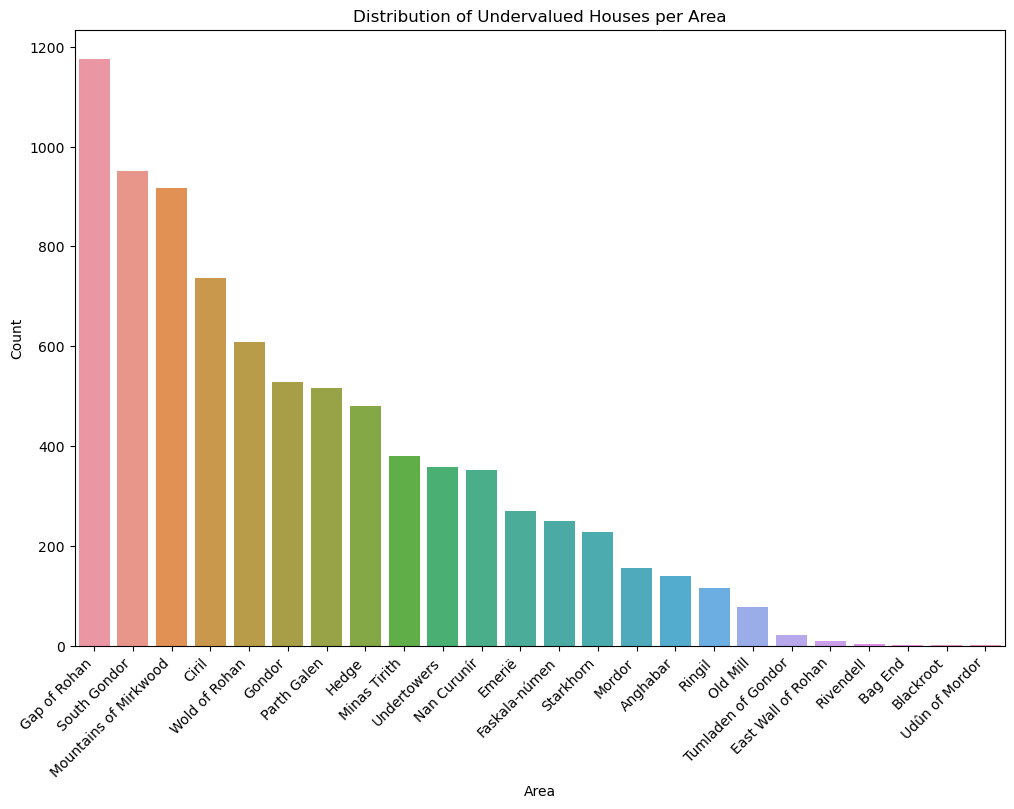

In [32]:
plt.figure(figsize=(12, 8))
sns.countplot(undervalued_houses, x="area", order = undervalued_houses["area"].value_counts().index)
plt.xlabel('Area')
plt.ylabel('Count')
plt.title("Distribution of Undervalued Houses per Area")
plt.xticks(rotation=45, ha='right')
plt.show()

In [33]:
# Performing a left join with an indicator
merged_df = pd.merge(old_market_houses, undervalued_houses[['address']], on='address', how='left', indicator=True)

# Creating a new column 'undervalued' to indicate if a match was found
merged_df['undervalued'] = merged_df['_merge'] == 'both'

# Dropping the '_merge' column
merged_df = merged_df.drop(columns=['_merge'])

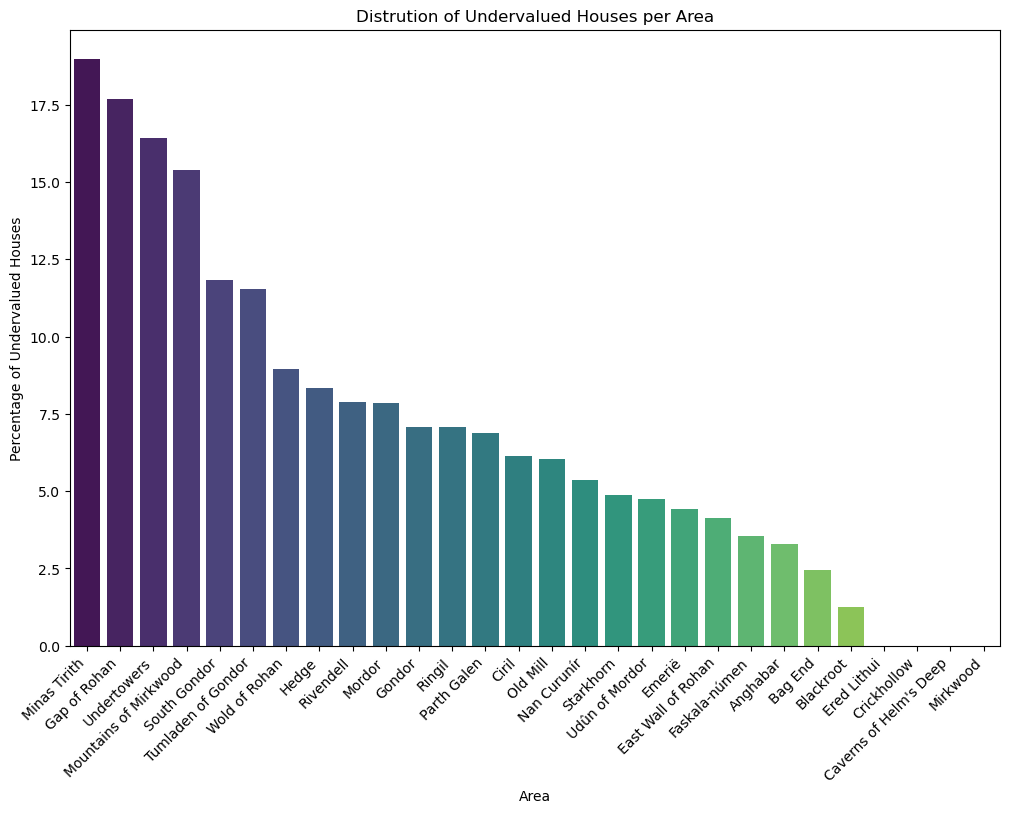

In [34]:
# Calculate percentages
value_counts = merged_df.groupby(['area', 'undervalued']).size().unstack(fill_value=0)
value_counts['percent_undervalued'] = (value_counts[True] / (value_counts[True] + value_counts[False])) * 100

# Reset index for easier plotting and sort by percentage undervalued
value_counts = value_counts.reset_index().sort_values(by='percent_undervalued', ascending=False)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='area', y='percent_undervalued', data=value_counts, palette='viridis')
plt.xlabel('Area')
plt.ylabel('Percentage of Undervalued Houses')
plt.title("Distrution of Undervalued Houses per Area")
plt.xticks(rotation=45, ha='right')
plt.show()

### K-mean Clustering (WIP)

In [35]:
me_clustered_final_df = me_df.copy()

In [36]:
# Select relevant columns
k_means_features = me_df[['building.area', 'price_deviation_area']]

# Handle NULL values
k_means_training = k_means_features.fillna(k_means_features.mean())

# Standardizing the scale of numerical values
scaler = StandardScaler()
k_means_training = scaler.fit_transform(k_means_training)

#### K-means: Determining the right number of clusters

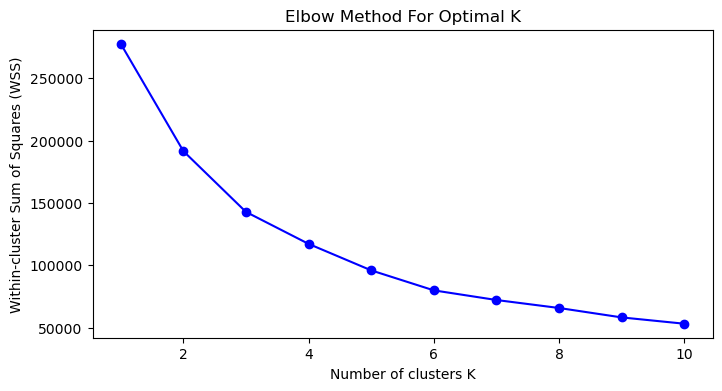

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# Calculating WSS for different values of k
wss = []
K_range = range(1, 11)  # Testing 1 to 10 clusters
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(k_means_training)
    wss.append(kmeans.inertia_)  # Inertia: Sum of squared distances of samples to their closest cluster center

# Plotting the results
plt.figure(figsize=(8, 4))
plt.plot(K_range, wss, 'bo-')
plt.xlabel('Number of clusters K')
plt.ylabel('Within-cluster Sum of Squares (WSS)')
plt.title('Elbow Method For Optimal K')
plt.show()

In [38]:
n_clusters = 5
print(f"Based on results of Elbow Method, the appropriate number of clusters is: {n_clusters}")

Based on results of Elbow Method, the appropriate number of clusters is: 5


#### K-means: Defining the clusters

In [39]:
# Initialize and fit the K-means model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(k_means_training)

# Get the cluster centers and labels
centers = kmeans.cluster_centers_
labels = kmeans.labels_

# Get Ys
y_kmeans = kmeans.predict(k_means_training)

# Reduce the data to 2 dimensions using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(k_means_training)

#### K-means: Visualizing the clusters

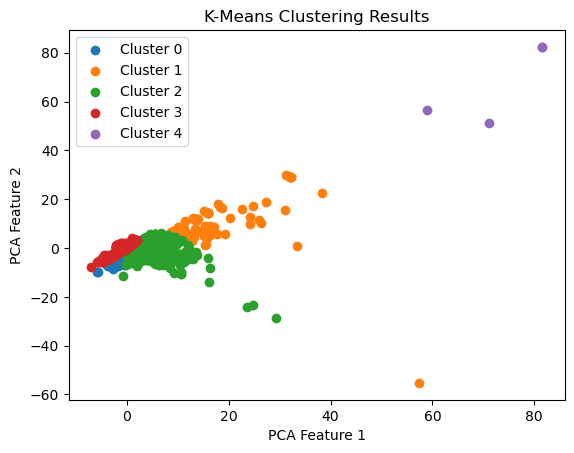

In [40]:
# Plotting
unique_labels = set(labels)

for label in unique_labels:
    plt.scatter(X_pca[labels == label, 0], X_pca[labels == label, 1], label=f'Cluster {label}', )

#plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)

plt.legend()
plt.title('K-Means Clustering Results')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.show()

In [41]:
for i, centroid in enumerate(centers):
    print(f"\nCentroid {i+1}:")
    for j, value in enumerate(centroid):
        print(f"  Feature {j+1}: {value:.2f}")


Centroid 1:
  Feature 1: 0.46
  Feature 2: 0.00

Centroid 2:
  Feature 1: 4.87
  Feature 2: 19.75

Centroid 3:
  Feature 1: 1.93
  Feature 2: 0.87

Centroid 4:
  Feature 1: -0.66
  Feature 2: -0.19

Centroid 5:
  Feature 1: 3.68
  Feature 2: 99.93


In [42]:
me_clustered_df = me_df.copy()
me_clustered_df['cluster'] = kmeans.labels_

me_clustered_small_df = k_means_features.copy()
me_clustered_small_df['cluster'] = kmeans.labels_
me_clustered_small_df['address'] = me_df['address']

me_clustered_df.head() 

,epoch.of.history,address,area,dwelling.type,dwell.sub.type,tax.class,sale.date,sale.price,year.built,number.of.units,land.area,building.area,sale_year,price_deviation_area,cluster
0,Fourth Age,2206 Mandos Way,Minas Tirith,One Family,Human house,A1,1241-02-20,300000.0,1131,1.0,1103.0,1290.0,1241.0,-282511.280638,3
1,Fourth Age,4312 W Rauros Circle,Minas Tirith,One Family,Hobbit hole,S1,1241-07-01,400000.0,1131,1.0,2500.0,2452.0,1241.0,-182511.280638,0
2,Fourth Age,2504 Harad Circle,Minas Tirith,One Family,Human house,S0,1241-01-06,510000.0,1152,1.0,1911.0,4080.0,1241.0,-72511.280638,2
3,Fourth Age,1087 Moria Circle,Minas Tirith,Two Family,Hobbit hole,B1,1241-08-04,430000.0,1214,2.0,2000.0,2400.0,1241.0,-152511.280638,0
4,Fourth Age,1904 Túna Street,Minas Tirith,Two Family,Hobbit hole,B1,1241-01-29,389000.0,1216,2.0,2451.0,2394.0,1241.0,-193511.280638,0


In [43]:
me_clustered_small_df.loc[:, me_clustered_small_df.columns != 'address'].groupby("cluster").describe().transpose()

cluster                                0             1             2  \
building.area        count  5.009500e+04  8.400000e+01  1.344700e+04   
                     mean   2.344082e+03  6.189821e+03  3.630298e+03   
                     std    3.799660e+02  7.914156e+03  1.009553e+03   
                     min    1.400000e+03  1.904000e+03  1.200000e+03   
                     25%    2.040000e+03  3.000000e+03  3.160000e+03   
                     50%    2.265000e+03  3.913500e+03  3.432000e+03   
                     75%    2.580000e+03  7.114500e+03  3.864000e+03   
                     max    5.803000e+03  7.144800e+04  3.775100e+04   
price_deviation_area count  5.032400e+04  8.400000e+01  1.344700e+04   
                     mean   2.686834e+03  1.479841e+07  6.562607e+05   
                     std    4.067031e+05  7.018391e+06  9.359888e+05   
                     min   -8.390118e+06  1.127729e+06 -6.465118e+06   
                     25%   -1.731774e+05  1.006375e+07  1.174887e+05   
                     50%    1.655068e+04  1.329489e+07  4.127292e+05   
                     75%    2.043530e+05  1.639791e+07  9.077292e+05   
                     max    2.529028e+06  3.248975e+07  7.385924e+06   

cluster                                3             4  
building.area        count  7.503800e+04  4.000000e+00  
                     mean   1.361527e+03  5.145500e+03  
                     std    2.864304e+02  6.142863e+03  
                     min    1.000000e+00  1.392000e+03  
                     25%    1.168000e+03  1.428000e+03  
                     50%    1.360000e+03  2.475000e+03  
                     75%    1.590000e+03  6.192500e+03  
                     max    2.760000e+03  1.424000e+04  
price_deviation_area count  7.504200e+04  4.000000e+00  
                     mean  -1.399552e+05  7.487633e+07  
                     std    2.615821e+05  1.386745e+07  
                     min   -7.754569e+06  6.112493e+07  
                     25%   -2.605935e+05  6.384030e+07  
                     50%   -1.194692e+05  7.578146e+07  
                     75%   -2.546239e+02  8.681749e+07  
                     max    2.738142e+06  8.681749e+07

1. Group 0:
    * Prefers deliveries over takeaway but very rarely orders (once or twice a year)
2. Group 1:
    * Orders regularly, every couple of weeks, almost only delivers
3. Group 2:
    * Orders every so often, orders takeaway almost as much as it deliveries
4. Group 3:
    * Rarely places orders (one a month is not rare) and when it does it almost always orders delivery.

In [44]:
me_clustered_df['cluster'].value_counts()

cluster
3    75042
0    50324
2    13447
1       84
4        4
Name: count, dtype: int64

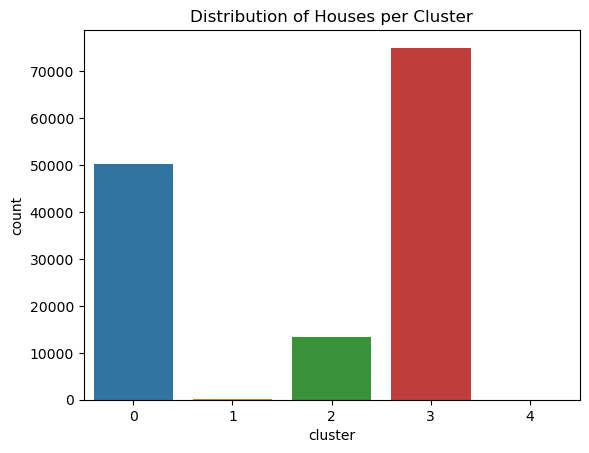

In [45]:
sns.countplot(me_clustered_df, x='cluster')
plt.title("Distribution of Houses per Cluster")
plt.show()

In [46]:
me_clustered_small_df[me_clustered_small_df['cluster'] == 4]

,building.area,price_deviation_area,cluster,address
108517,14240.0,6.474543e+07,4,943 Cristhorn Circle
123586,1440.0,8.681749e+07,4,489 Umbar Street
123587,1392.0,8.681749e+07,4,565 Ninglor Circle
127435,3510.0,6.112493e+07,4,3927 Great Willow Road


#### Finding the undervalued homes

In [47]:
# Check for inf values in the 'Values' column
sale_has_inf = np.isinf(me_clustered_df['sale.price']).any()
build_has_inf = np.isinf(me_clustered_df['building.area']).any()

print("Is there any 'inf' value in the 'sale.price' column? ", sale_has_inf)
print("Is there any 'inf' value in the 'building.area' column? ", build_has_inf)

Is there any 'inf' value in the 'sale.price' column?  False
Is there any 'inf' value in the 'building.area' column?  False


In [48]:
zero_count = (me_clustered_df['building.area'] == 0).sum()

# Calculate the total number of rows
total_rows = len(me_clustered_df)

# Compute the percentage
percentage_zero = (zero_count / total_rows) * 100

print(f"Percentage of rows where 'Building Area' is zero: {percentage_zero:.2f}%")

Percentage of rows where 'Building Area' is zero: 0.00%


In [49]:
me_clustered_df['price_per_square'] = me_clustered_df['sale.price']/me_clustered_df['building.area']

In [50]:
me_clustered_df['avg_price_per_square'] = me_clustered_df.groupby('cluster')['price_per_square'].transform('mean')

In [51]:
me_clustered_df.head()

,epoch.of.history,address,area,dwelling.type,dwell.sub.type,tax.class,sale.date,sale.price,year.built,number.of.units,land.area,building.area,sale_year,price_deviation_area,cluster,price_per_square,avg_price_per_square
0,Fourth Age,2206 Mandos Way,Minas Tirith,One Family,Human house,A1,1241-02-20,300000.0,1131,1.0,1103.0,1290.0,1241.0,-282511.280638,3,232.558140,464.820845
1,Fourth Age,4312 W Rauros Circle,Minas Tirith,One Family,Hobbit hole,S1,1241-07-01,400000.0,1131,1.0,2500.0,2452.0,1241.0,-182511.280638,0,163.132137,348.226316
2,Fourth Age,2504 Harad Circle,Minas Tirith,One Family,Human house,S0,1241-01-06,510000.0,1152,1.0,1911.0,4080.0,1241.0,-72511.280638,2,125.000000,469.087790
3,Fourth Age,1087 Moria Circle,Minas Tirith,Two Family,Hobbit hole,B1,1241-08-04,430000.0,1214,2.0,2000.0,2400.0,1241.0,-152511.280638,0,179.166667,348.226316
4,Fourth Age,1904 Túna Street,Minas Tirith,Two Family,Hobbit hole,B1,1241-01-29,389000.0,1216,2.0,2451.0,2394.0,1241.0,-193511.280638,0,162.489557,348.226316


In [52]:
from scipy.stats import trim_mean

# Function to calculate trimmed mean
def trimmed_mean(series, proportion_to_cut):
    return trim_mean(series, proportion_to_cut)

# Calculate the trimmed mean for each group and transform the results
proportion_to_cut = 0.1  # Adjust this value as needed
me_clustered_df['avg_trimmed_price_per_square'] = me_clustered_df.groupby('cluster')['price_per_square'].transform(lambda x: trimmed_mean(x, proportion_to_cut))

In [53]:
me_clustered_df.head()

,epoch.of.history,address,area,dwelling.type,dwell.sub.type,tax.class,sale.date,sale.price,year.built,number.of.units,land.area,building.area,sale_year,price_deviation_area,cluster,price_per_square,avg_price_per_square,avg_trimmed_price_per_square
0,Fourth Age,2206 Mandos Way,Minas Tirith,One Family,Human house,A1,1241-02-20,300000.0,1131,1.0,1103.0,1290.0,1241.0,-282511.280638,3,232.558140,464.820845,403.446724
1,Fourth Age,4312 W Rauros Circle,Minas Tirith,One Family,Hobbit hole,S1,1241-07-01,400000.0,1131,1.0,2500.0,2452.0,1241.0,-182511.280638,0,163.132137,348.226316,327.772536
2,Fourth Age,2504 Harad Circle,Minas Tirith,One Family,Human house,S0,1241-01-06,510000.0,1152,1.0,1911.0,4080.0,1241.0,-72511.280638,2,125.000000,469.087790,399.063239
3,Fourth Age,1087 Moria Circle,Minas Tirith,Two Family,Hobbit hole,B1,1241-08-04,430000.0,1214,2.0,2000.0,2400.0,1241.0,-152511.280638,0,179.166667,348.226316,327.772536
4,Fourth Age,1904 Túna Street,Minas Tirith,Two Family,Hobbit hole,B1,1241-01-29,389000.0,1216,2.0,2451.0,2394.0,1241.0,-193511.280638,0,162.489557,348.226316,327.772536


In [54]:
me_clustered_df[['cluster', 'price_per_square', 'avg_price_per_square', 'avg_trimmed_price_per_square', 'sale.price']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cluster,138901.0,1.815106,1.398574,0.000000,0.000000,3.000000,3.000000,4.000000e+00
price_per_square,138668.0,426.446196,4941.000158,7.351316,258.485903,360.000000,490.384615,1.425550e+06
avg_price_per_square,138901.0,426.318343,223.079037,348.226316,348.226316,464.820845,464.820845,3.663999e+04
avg_trimmed_price_per_square,138901.0,378.836637,217.251728,327.772536,327.772536,403.446724,403.446724,3.663999e+04
sale.price,138901.0,761751.701305,900249.014163,30500.000000,442000.000000,618000.000000,866169.000000,8.740000e+07


**Methods to find "undervalued homes"**
1. Find houses which price_per_square are significantly lower than avg_trimmed_price_per_square
2. Use Interquartile Range (IQR)

In [55]:
def percent_difference(average_price_per_square, price_per_square):
        percent_diff = ((price_per_square - average_price_per_square) / average_price_per_square) * 100
        percent_diff[price_per_square >= average_price_per_square] = float('nan')
    
        return percent_diff.abs()

In [56]:
me_clustered_df['percent_difference'] = percent_difference(me_clustered_df['avg_trimmed_price_per_square'], me_clustered_df['price_per_square'])
me_clustered_df.head()

,epoch.of.history,address,area,dwelling.type,dwell.sub.type,tax.class,sale.date,sale.price,year.built,number.of.units,land.area,building.area,sale_year,price_deviation_area,cluster,price_per_square,avg_price_per_square,avg_trimmed_price_per_square,percent_difference
0,Fourth Age,2206 Mandos Way,Minas Tirith,One Family,Human house,A1,1241-02-20,300000.0,1131,1.0,1103.0,1290.0,1241.0,-282511.280638,3,232.558140,464.820845,403.446724,42.357162
1,Fourth Age,4312 W Rauros Circle,Minas Tirith,One Family,Hobbit hole,S1,1241-07-01,400000.0,1131,1.0,2500.0,2452.0,1241.0,-182511.280638,0,163.132137,348.226316,327.772536,50.230078
2,Fourth Age,2504 Harad Circle,Minas Tirith,One Family,Human house,S0,1241-01-06,510000.0,1152,1.0,1911.0,4080.0,1241.0,-72511.280638,2,125.000000,469.087790,399.063239,68.676644
3,Fourth Age,1087 Moria Circle,Minas Tirith,Two Family,Hobbit hole,B1,1241-08-04,430000.0,1214,2.0,2000.0,2400.0,1241.0,-152511.280638,0,179.166667,348.226316,327.772536,45.338109
4,Fourth Age,1904 Túna Street,Minas Tirith,Two Family,Hobbit hole,B1,1241-01-29,389000.0,1216,2.0,2451.0,2394.0,1241.0,-193511.280638,0,162.489557,348.226316,327.772536,50.426122


In [57]:
cluster_0 = me_clustered_df[me_clustered_df['cluster'] == 0]

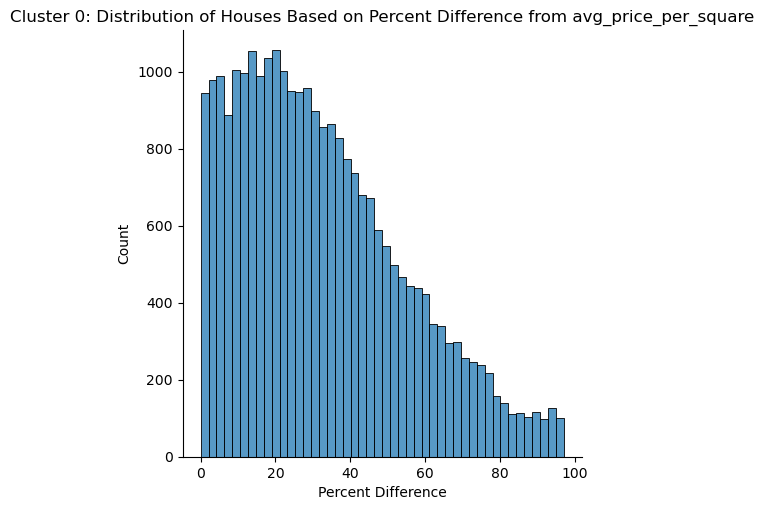

In [58]:
sns.displot(cluster_0, x="percent_difference")
plt.title("Cluster 0: Distribution of Houses Based on Percent Difference from avg_price_per_square")
plt.xlabel("Percent Difference")
plt.show()

In [59]:
cluster_0[cluster_0['percent_difference'] >= 80][['area','building.area', 'sale.price']].head(10)

,area,building.area,sale.price
10,Minas Tirith,2316.0,128778.0
172,Gondor,2270.0,95000.0
237,Minas Tirith,2357.0,75376.0
282,Gondor,3132.0,179000.0
283,Gondor,2466.0,39000.0
378,Gondor,2860.0,130000.0
379,Gondor,2860.0,130000.0
473,Mordor,2008.0,100000.0
514,Mordor,2860.0,120000.0
684,Gondor,2126.0,108750.0


In [60]:
cluster_0[cluster_0['percent_difference'] <= 20][['area','building.area', 'sale.price']].head(10)

,area,building.area,sale.price
147,Gondor,1970.0,560000.0
149,Gondor,2040.0,545000.0
155,Gondor,1894.0,610844.0
167,Gondor,1952.0,545000.0
318,Minas Tirith,2209.0,597000.0
319,Minas Tirith,2209.0,589000.0
320,Gondor,2321.0,641304.0
387,Gondor,2748.0,850000.0
389,Gondor,1920.0,570000.0
390,Gondor,2040.0,550000.0


**Evaluation:**
These are the areas I must evaluate:
* Clustering method
* Clustering features
* Number of cluster
* Clusters
* Undervalued homes

In [61]:
me_clustered_df['undervalued'] = np.where(me_clustered_df['percent_difference'] >=  80, True, False)

cluster_summary = me_clustered_df.groupby('cluster').agg({
    'price_per_square': ['mean', 'std', 'median', 'count'],
    'undervalued': 'sum'
}).reset_index()

undervalued_summary = me_clustered_df[me_clustered_df['undervalued']].groupby('cluster')['price_per_square'].agg(['mean', 'std', 'median']).reset_index()


In [62]:
print("Cluster Summary Statistics:")
cluster_summary

Cluster Summary Statistics:


cluster price_per_square                                    undervalued
                      mean           std        median  count         sum
0       0       348.226316    200.616397    315.126050  50095         915
1       1      4243.259224   2313.940571   4322.397345     84           1
2       2       469.087790    399.574394    361.344538  13447         260
3       3       464.820845   6702.801856    391.355140  75038         833
4       4     36639.986068  29424.699165  39179.131054      4           1

In [63]:
print("Undervalued Houses Summary Statistics:")
undervalued_summary

Undervalued Houses Summary Statistics:


,cluster,mean,std,median
0,0,38.869684,16.279193,38.998358
1,1,30.091815,NaN,30.091815
2,2,52.648560,18.792995,56.947930
3,3,53.161624,18.038904,54.106715
4,4,5414.325843,NaN,5414.325843


In [64]:
me_clustered_df.head()

,epoch.of.history,address,area,dwelling.type,dwell.sub.type,tax.class,sale.date,sale.price,year.built,number.of.units,land.area,building.area,sale_year,price_deviation_area,cluster,price_per_square,avg_price_per_square,avg_trimmed_price_per_square,percent_difference,undervalued
0,Fourth Age,2206 Mandos Way,Minas Tirith,One Family,Human house,A1,1241-02-20,300000.0,1131,1.0,1103.0,1290.0,1241.0,-282511.280638,3,232.558140,464.820845,403.446724,42.357162,False
1,Fourth Age,4312 W Rauros Circle,Minas Tirith,One Family,Hobbit hole,S1,1241-07-01,400000.0,1131,1.0,2500.0,2452.0,1241.0,-182511.280638,0,163.132137,348.226316,327.772536,50.230078,False
2,Fourth Age,2504 Harad Circle,Minas Tirith,One Family,Human house,S0,1241-01-06,510000.0,1152,1.0,1911.0,4080.0,1241.0,-72511.280638,2,125.000000,469.087790,399.063239,68.676644,False
3,Fourth Age,1087 Moria Circle,Minas Tirith,Two Family,Hobbit hole,B1,1241-08-04,430000.0,1214,2.0,2000.0,2400.0,1241.0,-152511.280638,0,179.166667,348.226316,327.772536,45.338109,False
4,Fourth Age,1904 Túna Street,Minas Tirith,Two Family,Hobbit hole,B1,1241-01-29,389000.0,1216,2.0,2451.0,2394.0,1241.0,-193511.280638,0,162.489557,348.226316,327.772536,50.426122,False


In [65]:
me_clustered_df.describe(include='object')

,epoch.of.history,address,area,dwelling.type,dwell.sub.type,tax.class,sale.date
count,138901,138901,138901,138901,138901,138901,138746
unique,1,138901,29,3,4,18,1892
top,Fourth Age,2206 Mandos Way,Ciril,One Family,Human house,A1,1243-10-30
freq,138901,1,16826,71518,67288,26998,175


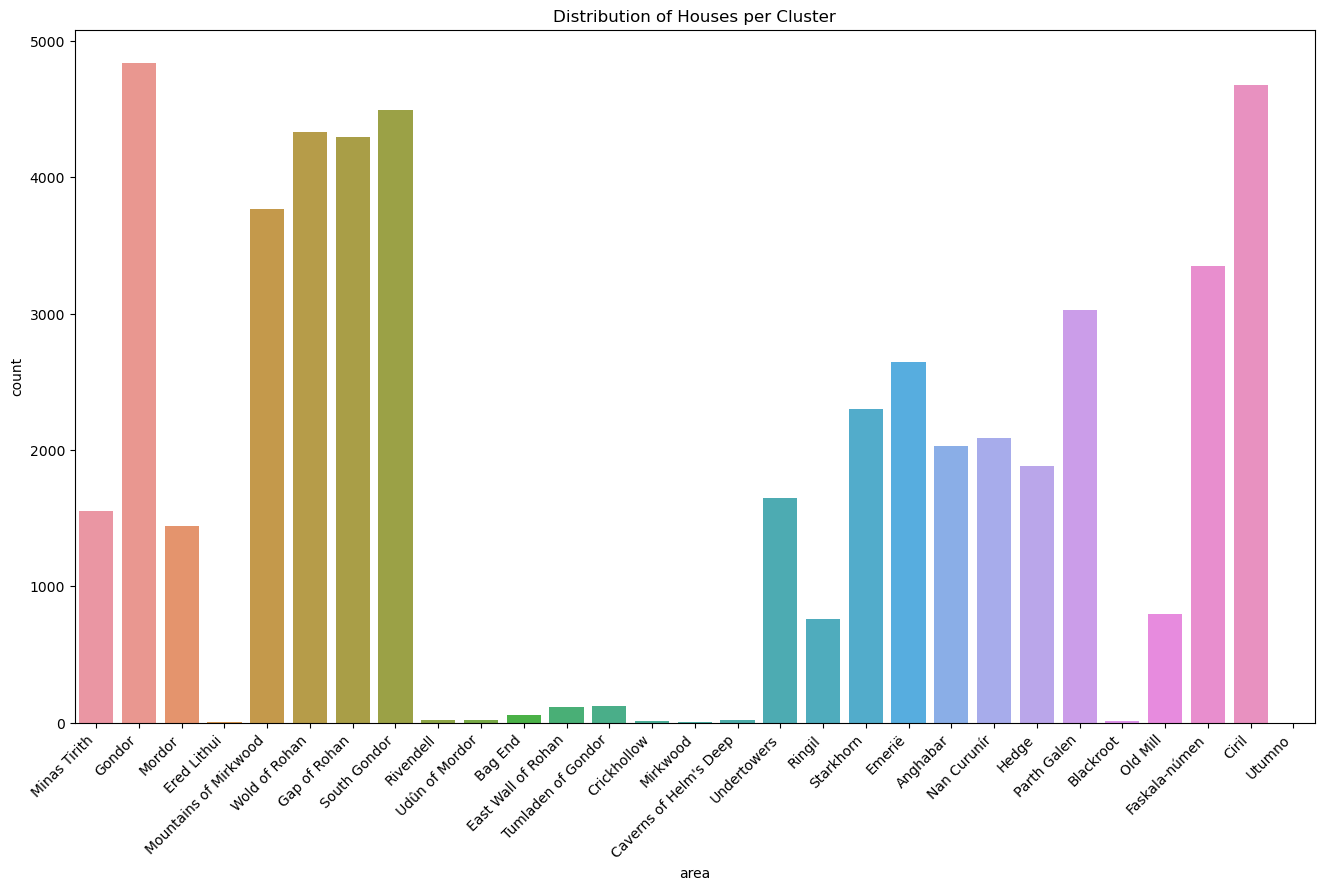

In [66]:
plt.figure(figsize=(16, 9))
sns.countplot(me_clustered_df[me_clustered_df['cluster'] == 0], x='area')
plt.title("Distribution of Houses per Cluster")
plt.xticks(rotation=45, ha='right')
plt.show()

#### Results

Based on the analysis above, I was able to derive an approach for finding which houses were "undervalued". This approach can be used on new data to determine potentia areas of investment.

**Undervalued Homes:**
Below is a list of houses which are considered undervalued. Houses are considered undervalued if the difference
between their `price_per_square` is 80% or higher from the `average price_per_square` of houses similar (based on \
physical characteristic and location) 
to it

In [67]:
me_clustered_df[me_clustered_df['undervalued'] == True]

,epoch.of.history,address,area,dwelling.type,dwell.sub.type,tax.class,sale.date,sale.price,year.built,number.of.units,land.area,building.area,sale_year,price_deviation_area,cluster,price_per_square,avg_price_per_square,avg_trimmed_price_per_square,percent_difference,undervalued
8,Fourth Age,2716 N Ringil Circle,Minas Tirith,Two Family,Human house,B3,1241-08-20,100000.0,1120,2.0,1592.0,1860.0,1241.0,-482511.280638,3,53.763441,464.820845,403.446724,86.673968,True
10,Fourth Age,2318 Ringil View,Minas Tirith,Two Family,Human house,B2,1241-05-29,128778.0,1120,2.0,3525.0,2316.0,1241.0,-453733.280638,0,55.603627,348.226316,327.772536,83.035910,True
24,Fourth Age,3948 Tongue Road,Gondor,One Family,Orc lair,A5,1241-03-19,72500.0,1171,1.0,1494.0,1512.0,1241.0,-432778.701440,3,47.949735,464.820845,403.446724,88.114977,True
25,Fourth Age,3241 Mordor Way,Gondor,One Family,Orc lair,A5,1241-03-16,72500.0,1171,1.0,1494.0,1512.0,1241.0,-432778.701440,3,47.949735,464.820845,403.446724,88.114977,True
46,Fourth Age,2754 Arnach Way,Gondor,One Family,Human house,A1,1241-07-23,110000.0,1141,1.0,2774.0,1378.0,1241.0,-395278.701440,3,79.825835,464.820845,403.446724,80.214033,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139479,Fourth Age,989 Minas Morgul Avenue,Faskala-númen,Three Family,Elf house,C0,1246-11-05,100000.0,1120,3.0,4218.0,1920.0,1246.0,-445254.623943,3,52.083333,464.820845,403.446724,87.090406,True
139573,Fourth Age,4612 Undying Lands Circle,Ciril,One Family,Elf house,A1,1246-09-11,165000.0,1176,1.0,4100.0,2667.0,1246.0,-364469.205575,0,61.867267,348.226316,327.772536,81.124939,True
139577,Fourth Age,1851 Kirith Ungol Parkway,Ciril,One Family,Human house,A5,1246-02-21,56190.0,1219,1.0,2548.0,1680.0,1246.0,-473279.205575,3,33.446429,464.820845,403.446724,91.709828,True
139604,Fourth Age,389 Hither Shore Circle,Ciril,One Family,Human house,A5,1246-02-21,50000.0,1212,1.0,1312.0,1032.0,1246.0,-479469.205575,3,48.449612,464.820845,403.446724,87.991076,True


### K-prototype Clustering (WIP)
Use k-prototypes to segment the houses, since it is able to hangle categorical and numerical features. 

In [68]:
# A copy of the entire dataset which we will use later to find the undervalued homes 
me_clustered_df = me_df.copy()

In [69]:
# Verifying that the features selected for training are correct before we proceed
clustering_features_raw.head()

,year.built,area,dwell.sub.type
0,1131,Minas Tirith,Human house
1,1131,Minas Tirith,Hobbit hole
2,1152,Minas Tirith,Human house
3,1214,Minas Tirith,Hobbit hole
4,1216,Minas Tirith,Hobbit hole


In [70]:
# Convert categorical columns to categorical data type
for col in ['area', 'dwell.sub.type']:
    clustering_features_raw[col] = clustering_features_raw[col].astype('category')

In [71]:
# Reference of where the categorical values are position in the training dataset
cat_columns_pos = [1, 2]

#### KPrototype: Determining the right number of clusters

In [72]:
# Choose optimal K using Elbow method
cost = []
for cluster in range(1, 7):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 42)
        kprototype.fit_predict(clustering_features_raw, categorical = cat_columns_pos)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except Exception as e:
        print(e)
        break

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6


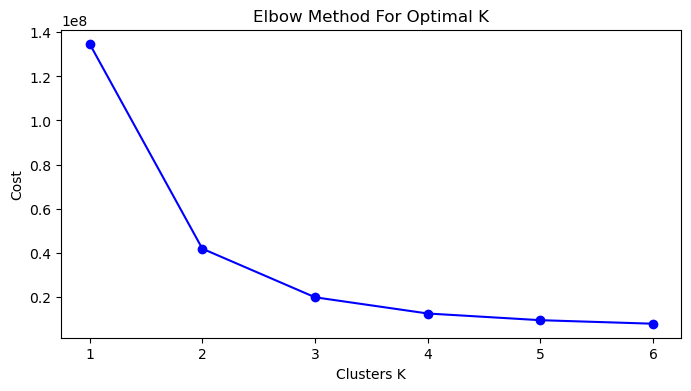

In [73]:
# Plotting the results
plt.figure(figsize=(8, 4))
plt.plot(range(1, 7), cost, 'bo-')
plt.xlabel('Clusters K')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal K')
plt.show()

#### KPrototype: Segmenting into clusters

In [74]:
num_clusters = 3

# Initialize and fit the K-prototypes model
kproto = KPrototypes(n_jobs = -1, n_clusters=num_clusters, init='Huang', random_state=42)
clusters = kproto.fit_predict(clustering_features_raw, categorical=cat_columns_pos)

In [75]:
# Add the cluster labels to the original dataframe
me_clustered_df['cluster'] = clusters

# Display the first few rows with cluster labels
me_clustered_df.head()

,epoch.of.history,address,area,dwelling.type,dwell.sub.type,tax.class,sale.date,sale.price,year.built,number.of.units,land.area,building.area,sale_year,price_deviation_area,cluster
0,Fourth Age,2206 Mandos Way,Minas Tirith,One Family,Human house,A1,1241-02-20,300000.0,1131,1.0,1103.0,1290.0,1241.0,-282511.280638,0
1,Fourth Age,4312 W Rauros Circle,Minas Tirith,One Family,Hobbit hole,S1,1241-07-01,400000.0,1131,1.0,2500.0,2452.0,1241.0,-182511.280638,0
2,Fourth Age,2504 Harad Circle,Minas Tirith,One Family,Human house,S0,1241-01-06,510000.0,1152,1.0,1911.0,4080.0,1241.0,-72511.280638,0
3,Fourth Age,1087 Moria Circle,Minas Tirith,Two Family,Hobbit hole,B1,1241-08-04,430000.0,1214,2.0,2000.0,2400.0,1241.0,-152511.280638,2
4,Fourth Age,1904 Túna Street,Minas Tirith,Two Family,Hobbit hole,B1,1241-01-29,389000.0,1216,2.0,2451.0,2394.0,1241.0,-193511.280638,2


#### KPrototype: Visually evaluating the Clusters

In [76]:
# Separate numerical and categorical features to make them easier to work with
numerical_features = me_clustered_df['year.built']
categorical_features = me_clustered_df[['area', 'dwelling.type', 'dwell.sub.type']]

In [77]:
# Apply MCA to the categorical features
mca = prince.MCA(n_components=2, random_state=42)
mca_fit = mca.fit(categorical_features)
mca_features = mca_fit.transform(categorical_features)

In [78]:
# Combine MCA results with the numerical feature for visualization
df_mca = mca_features
df_mca.columns = ['MCA1', 'MCA2']

df_mca['cluster'] = clusters
df_mca['year.built'] = numerical_features

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


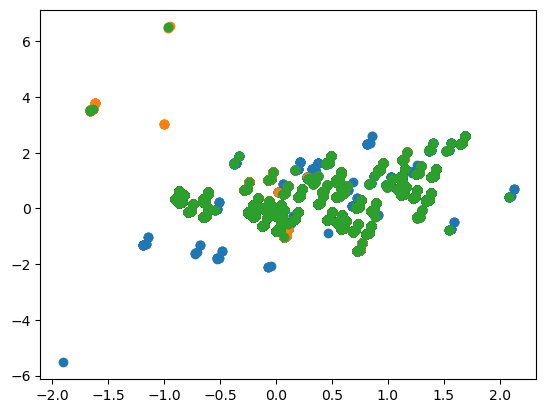

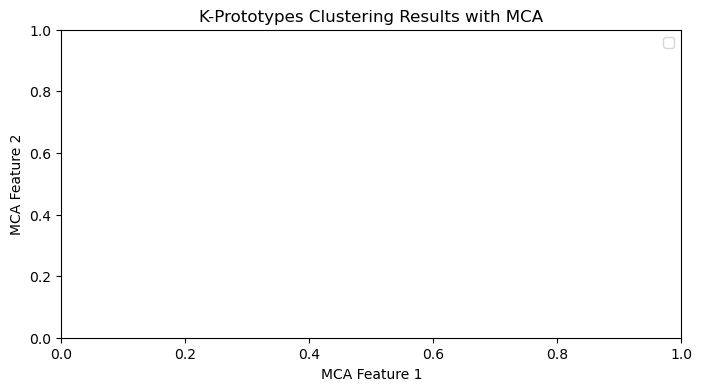

In [79]:
# Plotting
unique_labels = set(clusters)
for label in unique_labels:
    plt.scatter(df_mca[df_mca['cluster'] == label]['MCA1'], df_mca[df_mca['cluster'] == label]['MCA2'], label=f'Cluster {label}')

plt.figure(figsize=(8, 4))
plt.legend()
plt.title('K-Prototypes Clustering Results with MCA')
plt.xlabel('MCA Feature 1')
plt.ylabel('MCA Feature 2')
plt.show()

In [80]:
# Apply MCA to the categorical features
mca = prince.MCA(n_components=3, random_state=42)
mca_fit = mca.fit(categorical_features)
mca_features = mca_fit.transform(categorical_features)

# Combine MCA results with the numerical feature for visualization
df_mca = mca_features
df_mca.columns = ['MCA1', 'MCA2', 'MCA3']

df_mca['cluster'] = clusters
df_mca['year.built'] = numerical_features

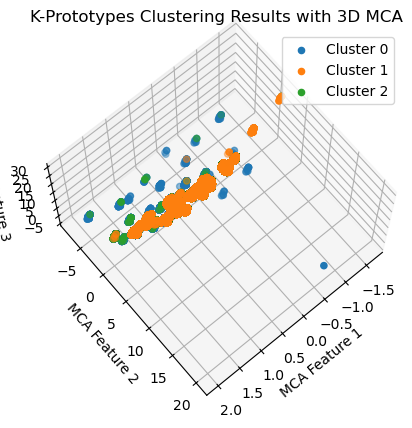

<Figure size 800x400 with 0 Axes>

In [81]:
# 3D Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
unique_labels = set(clusters)
for label in unique_labels:
    ax.scatter(df_mca[df_mca['cluster'] == label]['MCA1'], 
               df_mca[df_mca['cluster'] == label]['MCA2'], 
               df_mca[df_mca['cluster'] == label]['MCA3'], 
               label=f'Cluster {label}')

plt.figure(figsize=(8, 4))
ax.set_title('K-Prototypes Clustering Results with 3D MCA')
ax.set_xlabel('MCA Feature 1')
ax.set_ylabel('MCA Feature 2')
ax.set_zlabel('MCA Feature 3')

# Change the perspective
ax.view_init(elev=70, azim=50)  # Adjust the elevation and azimuthal angles

ax.legend()
plt.show()

In [82]:
me_clustered_df[me_clustered_df['cluster'] == 0]

,epoch.of.history,address,area,dwelling.type,dwell.sub.type,tax.class,sale.date,sale.price,year.built,number.of.units,land.area,building.area,sale_year,price_deviation_area,cluster
0,Fourth Age,2206 Mandos Way,Minas Tirith,One Family,Human house,A1,1241-02-20,300000.0,1131,1.0,1103.0,1290.0,1241.0,-282511.280638,0
1,Fourth Age,4312 W Rauros Circle,Minas Tirith,One Family,Hobbit hole,S1,1241-07-01,400000.0,1131,1.0,2500.0,2452.0,1241.0,-182511.280638,0
2,Fourth Age,2504 Harad Circle,Minas Tirith,One Family,Human house,S0,1241-01-06,510000.0,1152,1.0,1911.0,4080.0,1241.0,-72511.280638,0
7,Fourth Age,2162 Mindeb Lane,Minas Tirith,Two Family,Human house,S2,1241-09-28,490000.0,1152,2.0,1620.0,3240.0,1241.0,-92511.280638,0
8,Fourth Age,2716 N Ringil Circle,Minas Tirith,Two Family,Human house,B3,1241-08-20,100000.0,1120,2.0,1592.0,1860.0,1241.0,-482511.280638,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139478,Fourth Age,4045 Maggot's Lane Circle,Ciril,Three Family,Orc lair,C0,1246-05-15,675000.0,1126,3.0,6968.0,1152.0,1246.0,145530.794425,0
139479,Fourth Age,989 Minas Morgul Avenue,Faskala-númen,Three Family,Elf house,C0,1246-11-05,100000.0,1120,3.0,4218.0,1920.0,1246.0,-445254.623943,0
139491,Fourth Age,134 Frogmorton Terrace,Faskala-númen,One Family,Human house,A1,1246-03-05,605000.0,1120,1.0,3460.0,2570.0,1246.0,59745.376057,0
139549,Fourth Age,1761 Taur-en-Faroth Way,Faskala-númen,Two Family,Hobbit hole,B2,1246-10-30,705000.0,1126,2.0,4200.0,1888.0,1246.0,159745.376057,0


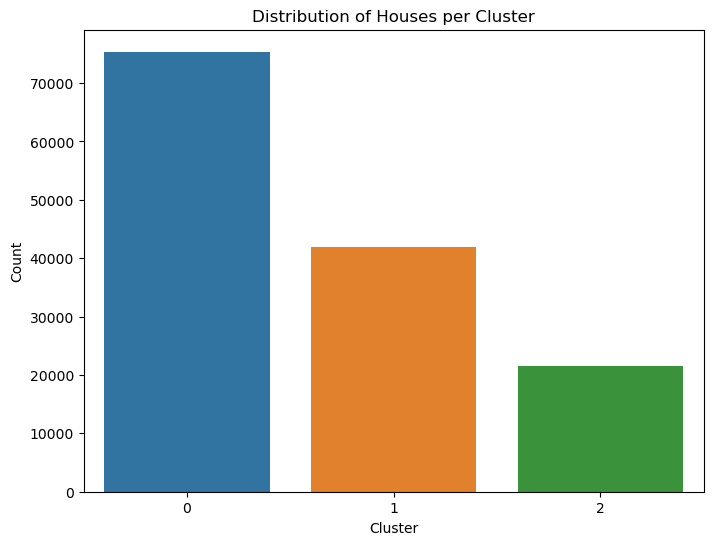

In [83]:

plt.figure(figsize=(8, 6))
sns.countplot(me_clustered_df, x='cluster')
plt.title("Distribution of Houses per Cluster")
plt.ylabel("Count")
plt.xlabel("Cluster")
plt.show()

In [84]:
me_clustered_df[['year.built', 'area', 'dwelling.type', 'dwell.sub.type', 'cluster']][me_clustered_df['cluster'] == 0].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
year.built,75358.0,1140.269023,11.471895,271.0,1131.0,1141.0,1151.0,1157.0
cluster,75358.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


### Regression (WIP)

#### Define constraints and pre-process data

In [85]:
features = ['area', 'building.area', 'number.of.units', 'sale.price', 'dwell.sub.type']

# For training, use houses that were sold between 1245-1246 since they will be considered to be price accurately
reg_features_df = me_df[me_df['sale_year'].isin([1245, 1246])][features]
reg_features_df.head()

,area,building.area,number.of.units,sale.price,dwell.sub.type
99407,Minas Tirith,1497.0,1.0,388500.0,Hobbit hole
99408,Minas Tirith,1260.0,1.0,110000.0,Hobbit hole
99409,Minas Tirith,2047.0,1.0,470000.0,Human house
99410,Minas Tirith,1344.0,1.0,420000.0,Human house
99411,Minas Tirith,2400.0,2.0,505000.0,Human house


In [86]:
reg_features_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
building.area,39885.0,1912.500338,8.620244e+02,1.0,1313.0,1728.0,2300.0,31393.0
number.of.units,39885.0,1.559484,6.638759e-01,1.0,1.0,1.0,2.0,30.0
sale.price,40117.0,870953.611611,1.361433e+06,31170.0,512500.0,680000.0,925000.0,87400000.0


In [87]:
print('The size of the dateset is: ' + str(len(reg_features_df)))

The size of the dateset is: 40117


In [88]:
# Let's remove rows where building.area is 0
reg_features_df = reg_features_df.dropna(how='any',axis=0)

In [89]:
check_data(reg_features_df)


,column,dtype,instances,unique,sum_null,duplicates
0,area,object,39885,28,0,452
1,building.area,float64,39885,3419,0,452
2,number.of.units,float64,39885,8,0,452
3,sale.price,float64,39885,5298,0,452
4,dwell.sub.type,object,39885,4,0,452


In [90]:
# Define features and target variable
X = reg_features_df[['area', 'dwell.sub.type', 'building.area', 'number.of.units']]
y = reg_features_df['sale.price']

# Preprocessing for numerical and categorical data
numerical_features = ['building.area', 'number.of.units']
categorical_features = ['area', 'dwell.sub.type']

In [91]:
# Function to cap outliers using IQR
def cap_outliers_iqr(df, features):
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[feature] = np.where(df[feature] > upper_bound, upper_bound, df[feature])
        df[feature] = np.where(df[feature] < lower_bound, lower_bound, df[feature])
    return df

df_capped = cap_outliers_iqr(reg_features_df, numerical_features)

In [92]:
df_capped.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
building.area,39885.0,1885.403899,7.335226e+02,1.0,1313.0,1728.0,2300.0,3780.5
number.of.units,39885.0,1.558481,6.467489e-01,1.0,1.0,1.0,2.0,3.5
sale.price,39885.0,873467.887176,1.364871e+06,31170.0,515000.0,682228.0,925000.0,87400000.0


#### Compare Results of different Regression approaches

In [93]:
def evaluate_models(df, target, numerical_features, categorical_features):
    # Split the data into features and target
    X = df[numerical_features + categorical_features]
    y = df[target]

    # Preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(), categorical_features)
        ])

    # Define models
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Huber Regressor': HuberRegressor()
    }

    results = {}

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    for name, model in models.items():
        # Create the pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])

        # Fit the model
        pipeline.fit(X_train, y_train)

        # Predict on the test set
        y_pred = pipeline.predict(X_test)

        # Evaluate the model
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Perform cross-validation
        # Use KFold for cross-validation
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(pipeline, X, y, cv=kf, scoring='neg_mean_squared_error')
        mean_cv_mse = -cv_scores.mean()

        # Store the results
        results[name] = {
            'MSE': mse,
            'R-squared': r2,
            'Cross-Validated MSE': mean_cv_mse
        }

        print(f'{name}:')
        print(f'  Mean Squared Error: {mse}')
        print(f'  R-squared: {r2}')
        print(f'  Cross-Validated Mean Squared Error: {mean_cv_mse}\n')

    return results

In [94]:
# Define the features and target
numerical_features = ['building.area', 'number.of.units']
categorical_features = ['area', 'dwell.sub.type']
target = 'sale.price'

# Evaluate the models
results = evaluate_models(df_capped, target, numerical_features, categorical_features)

Linear Regression:
  Mean Squared Error: 1591142483988.336
  R-squared: 0.2301938836650136
  Cross-Validated Mean Squared Error: nan

Random Forest:
  Mean Squared Error: 1238442384322.09
  R-squared: 0.40083271499988593
  Cross-Validated Mean Squared Error: nan

Huber Regressor:
  Mean Squared Error: 1877994271691.4702
  R-squared: 0.09141293671801687
  Cross-Validated Mean Squared Error: nan

